In [1]:
# 1. 라이브러리 불러오기
import pandas as pd
from konlpy.tag import Okt
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (윈도우 기준)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# 2. 데이터 불러오기
voc_df = pd.read_csv("./data/voc_data.csv", encoding="utf-8-sig")
inspection_df = pd.read_csv("./data/inspection_data.csv", encoding="utf-8-sig")
product_df = pd.read_csv("./data/product_data.csv", encoding="utf-8-sig")

# 3. 전처리 (형태소 분석 + 불용어 제거)
okt = Okt()
stopwords = ["이", "가", "은", "는", "에", "의", "도", "고", "와", "요", "있어요", "없어요", "해서"]
def preprocess_text(text):
    tokens = okt.morphs(text)
    return " ".join([t for t in tokens if t not in stopwords])
voc_df["전처리의견"] = voc_df["고객의견"].apply(preprocess_text)

# 4. 키워드 기반 분류
keyword_dict = {
    "정가품": ["정품", "가짜", "택", "인증"],
    "오염": ["오염", "얼룩", "먼지", "깨끗"],
    "포장불량": ["포장", "박스", "테이프", "엉망"],
    "배송지연": ["배송", "늦", "지연", "일주일"]
}
def classify_type(text):
    for label, keywords in keyword_dict.items():
        if any(k in text for k in keywords):
            return label
    return "기타"
voc_df["분류된유형"] = voc_df["전처리의견"].apply(classify_type)

# 5. VOC + 검수 merge (SKU, Date 기준)
merged_voc_inspection = pd.merge(voc_df, inspection_df, on=["SKU", "Date"], how="left")

# 6. product와 merge
merged_full = pd.merge(merged_voc_inspection, product_df, on="SKU", how="left")

# 7. 필요한 컬럼 정리
merged_full = merged_full[[
    "VOC_ID", "Date", "SKU", "브랜드", "카테고리", "매입수량",
    "고객의견", "전처리의견", "VOC유형", "분류된유형", "검수결과", "검수사유","감성점수"
]]

# 8. CSV 저장
merged_full.to_csv("./data/merged_voc_inspection_product.csv", index=False, encoding="utf-8-sig")


In [2]:
df = pd.read_csv("./data/merged_voc_inspection_product.csv", encoding="utf-8-sig")
print(df.columns)

Index(['VOC_ID', 'Date', 'SKU', '브랜드', '카테고리', '매입수량', '고객의견', '전처리의견',
       'VOC유형', '분류된유형', '검수결과', '검수사유', '감성점수'],
      dtype='object')


## 📊 VOC 유형별 분포 시각화

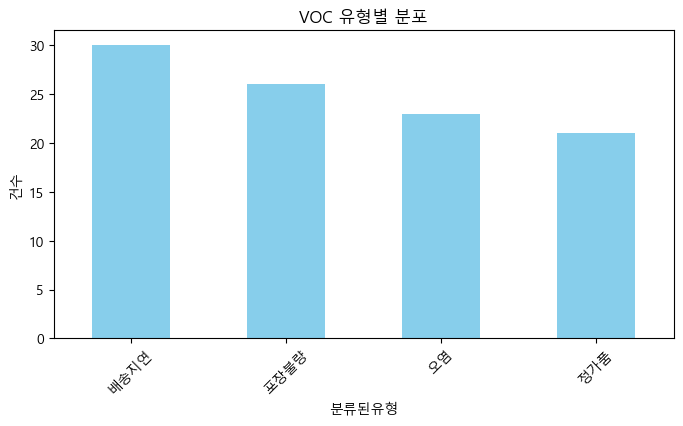

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
voc_df["분류된유형"].value_counts().plot(kind="bar", color="skyblue")
plt.title("VOC 유형별 분포")
plt.ylabel("건수")
plt.xticks(rotation=45)
plt.show()


## 📈 월별 VOC 트렌드 분석

<Figure size 1000x400 with 0 Axes>

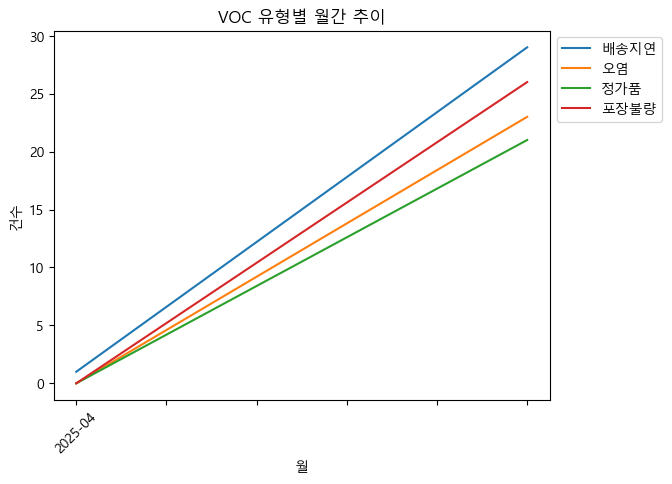

In [7]:
voc_df["Date"] = pd.to_datetime(voc_df["Date"], errors="coerce")

voc_df["월"] = voc_df["Date"].dt.to_period("M").astype(str)
trend = voc_df.groupby(["월", "분류된유형"]).size().unstack().fillna(0)

plt.figure(figsize=(10, 4))
trend.plot()
plt.title("VOC 유형별 월간 추이")
plt.ylabel("건수")
plt.xticks(rotation=45)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

## 📋 SKU별 VOC 건수

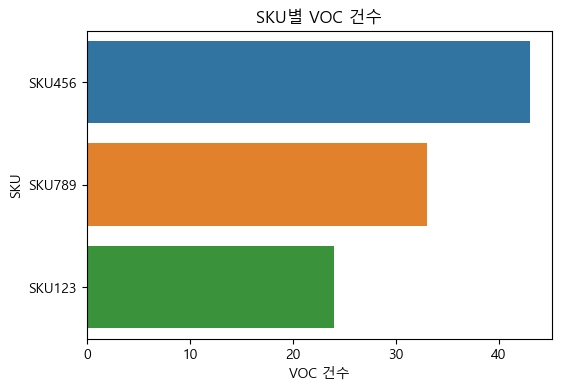

In [5]:
top_skus = voc_df["SKU"].value_counts().head(5)

plt.figure(figsize=(6, 4))
sns.barplot(x=top_skus.values, y=top_skus.index)
plt.xlabel("VOC 건수")
plt.ylabel("SKU")
plt.title("SKU별 VOC 건수")
plt.show()


## ❌ 브랜드별 검수 실패율

In [10]:
fail_rate_by_brand = (
    merged_voc_inspection.groupby("브랜드")["검수결과"]
    .apply(lambda x: (x == "FAIL").mean())
    .sort_values(ascending=False)
    .head(5)
)

plt.figure(figsize=(6, 4))
sns.barplot(x=fail_rate_by_brand.values, y=fail_rate_by_brand.index)
plt.xlabel("검수 실패율")
plt.ylabel("브랜드")
plt.title("브랜드별 검수 실패율 (Top5)")
plt.show()


KeyError: '브랜드'